In [1]:
import sys
sys.path.append('/accounts/grad/zhangyunzhe2023/tlide')

from typing import List, Optional
from llama import Dialog, Llama

import os
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
import seaborn as sns

# choose any free port
os.environ.setdefault("MASTER_ADDR", "127.0.0.1")
os.environ.setdefault("MASTER_PORT", "29500")
os.environ.setdefault("RANK", "0")
os.environ.setdefault("WORLD_SIZE", "1")
os.environ.setdefault("LOCAL_RANK", "0")

# if you have a CUDA GPU, use 'nccl'; otherwise use 'gloo'
backend = "nccl" if torch.cuda.is_available() else "gloo"
if backend == "nccl":
    torch.cuda.set_device(0)

dist.init_process_group(backend=backend)

In [2]:
generator = Llama.build(
    ckpt_dir='/accounts/grad/zhangyunzhe2023/.llama/checkpoints/Llama3.2-1B',
    tokenizer_path='/accounts/grad/zhangyunzhe2023/.llama/checkpoints/Llama3.2-1B/tokenizer.model',
    max_seq_len=8192,
    max_batch_size=1,
)

tokenizer = generator.tokenizer
model = generator.model.eval()
params = generator.model.params

> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1


/scratch/users/zhangyunzhe2023/conda/envs/torch28/lib/python3.13/site-packages/torch/__init__.py:1264: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


Loaded in 3.84 seconds


In [3]:
def merge_kv_cache(ks, vs):
    # k, v: (N, D)
    k_merged = ks.sum(dim=0)
    k_merged_norm_sq = torch.dot(k_merged, k_merged)
    alphas = torch.mv(ks, k_merged) / k_merged_norm_sq
    alpha_var = torch.var(alphas, unbiased=False)
    v_merged = vs.mean(dim=0)
    return k_merged, alpha_var, v_merged

def softmax_modified(x, alpha_vars, n_merged):
    to_exp = x / n_merged + alpha_vars * x.square() / 2
    to_exp = to_exp - to_exp.max(dim=-1, keepdim=True).values
    approx_merged_exp = n_merged * to_exp.exp()
    score = approx_merged_exp / approx_merged_exp.sum(dim=-1, keepdim=True)
    return score

def sdpa_modified(
    xq: torch.Tensor,          # (query_seq_len, head_dim)
    keys: torch.Tensor,        # (prev_seq_len, head_dim)
    values: torch.Tensor,      # (prev_seq_len, head_dim)
    alpha_vars: Optional[torch.Tensor]=None,  # (prev_seq_len,)
    n_merged: Optional[torch.Tensor]=None,    # (prev_seq_len,)
    mask: Optional[torch.Tensor] = None  # (query_seq_len, prev_seq_len) additive bias (e.g., -inf for masked)
) -> torch.Tensor:
    """
    Scaled dot-product attention for a single head and a single batch element.

    Returns:
        Tensor of shape (query_seq_len, head_dim).
    """
    # (Tq, D) @ (D, Tk) -> (Tq, Tk)
    head_dim = xq.shape[-1]
    scores = (xq @ keys.transpose(0, 1)) / math.sqrt(head_dim)

    if mask is not None:
        # mask is additive; same dtype broadcast rules as in your batched version
        # expected shape: (Tq, Tk) or broadcastable to it
        scores = scores + mask

    # Compute attention and bring back to original dtype
    if alpha_vars is not None and n_merged is not None:
        attn = softmax_modified(scores.float(), alpha_vars, n_merged).to(xq.dtype)
    else:
        attn = F.softmax(scores, dim=-1)

    # (Tq, Tk) @ (Tk, D) -> (Tq, D)
    out = attn @ values
    return out

In [4]:
def eval_kv_cache_compress(
    cache_k: torch.Tensor,
    cache_v: torch.Tensor,
    xq: torch.Tensor,
    merge_budget: int
):
    cos_sim = nn.CosineSimilarity(dim=1, eps=1e-8)
    s = cos_sim(cache_k[:-1], cache_k[1:])
    break_points = torch.argsort(s)[:merge_budget-1].sort()[0]
    break_points = break_points + 1
    break_points = break_points.cpu().numpy().tolist()
    break_points.insert(0, 0)
    break_points.append(1000000)

    compressed_cache_k = []
    compressed_cache_v = []
    alpha_vars = []
    n_merged = []
    compressed_cache_k_baseline = []
    compressed_cache_v_baseline = []
    for i in range(len(break_points) - 1):
        cache_k_chunk = cache_k[break_points[i]:break_points[i + 1]]
        cache_v_chunk = cache_v[break_points[i]:break_points[i + 1]]
        k_merged, alpha_var, v_merged = merge_kv_cache(cache_k_chunk, cache_v_chunk)
        compressed_cache_k.append(k_merged)
        compressed_cache_v.append(v_merged)
        alpha_vars.append(alpha_var)
        n_merged.append(cache_k_chunk.size(0))

        # Baseline merging: plain average
        compressed_cache_k_baseline.append(cache_k_chunk.mean(dim=0))
        compressed_cache_v_baseline.append(cache_v_chunk.mean(dim=0))

    compressed_cache_k = torch.stack(compressed_cache_k)
    compressed_cache_v = torch.stack(compressed_cache_v)
    alpha_vars = torch.stack(alpha_vars)
    n_merged = torch.tensor(n_merged)

    compressed_cache_k_baseline = torch.stack(compressed_cache_k_baseline)
    compressed_cache_v_baseline = torch.stack(compressed_cache_v_baseline)

    merged_errors = []
    merged_baseline_errors = []
    for i in range(4):
        result_merged = sdpa_modified(xq[:, i], compressed_cache_k, compressed_cache_v, alpha_vars, n_merged)
        result_merged_baseline = sdpa_modified(xq[:, i], compressed_cache_k_baseline, compressed_cache_v_baseline)
        result_exact = sdpa_modified(xq[:, i], cache_k, cache_v)

        result_exact_norm = result_exact.square().sum().sqrt()
        merged_error = (result_merged - result_exact).square().sum().sqrt() / result_exact_norm
        merged_baseline_error = (result_merged_baseline - result_exact).square().sum().sqrt() / result_exact_norm

        merged_errors.append(merged_error)
        merged_baseline_errors.append(merged_baseline_error)
    return torch.tensor(merged_errors), torch.tensor(merged_baseline_errors)

In [5]:
from datasets import load_dataset
dataset = load_dataset('THUDM/LongBench-v2', split='train')

In [6]:
record = np.zeros((8, 2, 16, 8, 4, 4)) # text_sample, method, layer, kv heads, budget, q heads
text_ids = list(range(8))
eval_layer_candidates = list(range(16))
eval_head_candidates = list(range(8))
budget_candidates = [1024, 2048, 4096, 6144]
eval_pos = 8191

for text_id in text_ids:
    text = dataset[text_id]['context']
    start = text.find('\n')
    text = text[start+1:]

    prompts: List[str] = [text]
    prompt_tokens = [tokenizer.encode(prompts[0], bos=True, eos=False)]
    tokens = torch.tensor(prompt_tokens, dtype=torch.long, device="cuda")

    _ = model.forward(tokens[:, 0:8192], 0, return_last_hidden=True)

    for eval_layer in eval_layer_candidates:
        print(f"Processing text {text_id}, layer {eval_layer}")
        for eval_head in eval_head_candidates:
            for budget_idx, budget in enumerate(budget_candidates):
                cache_k = model.layers[eval_layer].attention.cache_k[0, :eval_pos+1, eval_head]
                cache_v = model.layers[eval_layer].attention.cache_v[0, :eval_pos+1, eval_head]
                xq = model.layers[eval_layer].attention.cache_q[0, eval_pos:eval_pos+1, eval_head*4:eval_head*4+4]

                merged_errors, merged_baseline_errors = eval_kv_cache_compress(cache_k, cache_v, xq, merge_budget=budget)
                record[text_id, 0, eval_layer, eval_head, budget_idx] = merged_errors.cpu().numpy()
                record[text_id, 1, eval_layer, eval_head, budget_idx] = merged_baseline_errors.cpu().numpy()

Processing text 0, layer 0
Processing text 0, layer 1
Processing text 0, layer 2
Processing text 0, layer 3
Processing text 0, layer 4
Processing text 0, layer 5
Processing text 0, layer 6
Processing text 0, layer 7
Processing text 0, layer 8
Processing text 0, layer 9
Processing text 0, layer 10
Processing text 0, layer 11
Processing text 0, layer 12
Processing text 0, layer 13
Processing text 0, layer 14
Processing text 0, layer 15
Processing text 1, layer 0
Processing text 1, layer 1
Processing text 1, layer 2
Processing text 1, layer 3
Processing text 1, layer 4
Processing text 1, layer 5
Processing text 1, layer 6
Processing text 1, layer 7
Processing text 1, layer 8
Processing text 1, layer 9
Processing text 1, layer 10
Processing text 1, layer 11
Processing text 1, layer 12
Processing text 1, layer 13
Processing text 1, layer 14
Processing text 1, layer 15
Processing text 2, layer 0
Processing text 2, layer 1
Processing text 2, layer 2
Processing text 2, layer 3
Processing text 

In [7]:
torch.save(record, '/accounts/grad/zhangyunzhe2023/tlide/results.pt')

In [ ]:
# (8, 2, 16, 8, 4, 4) text_sample, method, layer, kv heads, budget, q heads
record = torch.load('/accounts/grad/zhangyunzhe2023/tlide/results.pt', weights_only=False)
record = record.mean(axis=(0, 5)) # Average over all samples and q heads (method, layer, kv heads, budget)

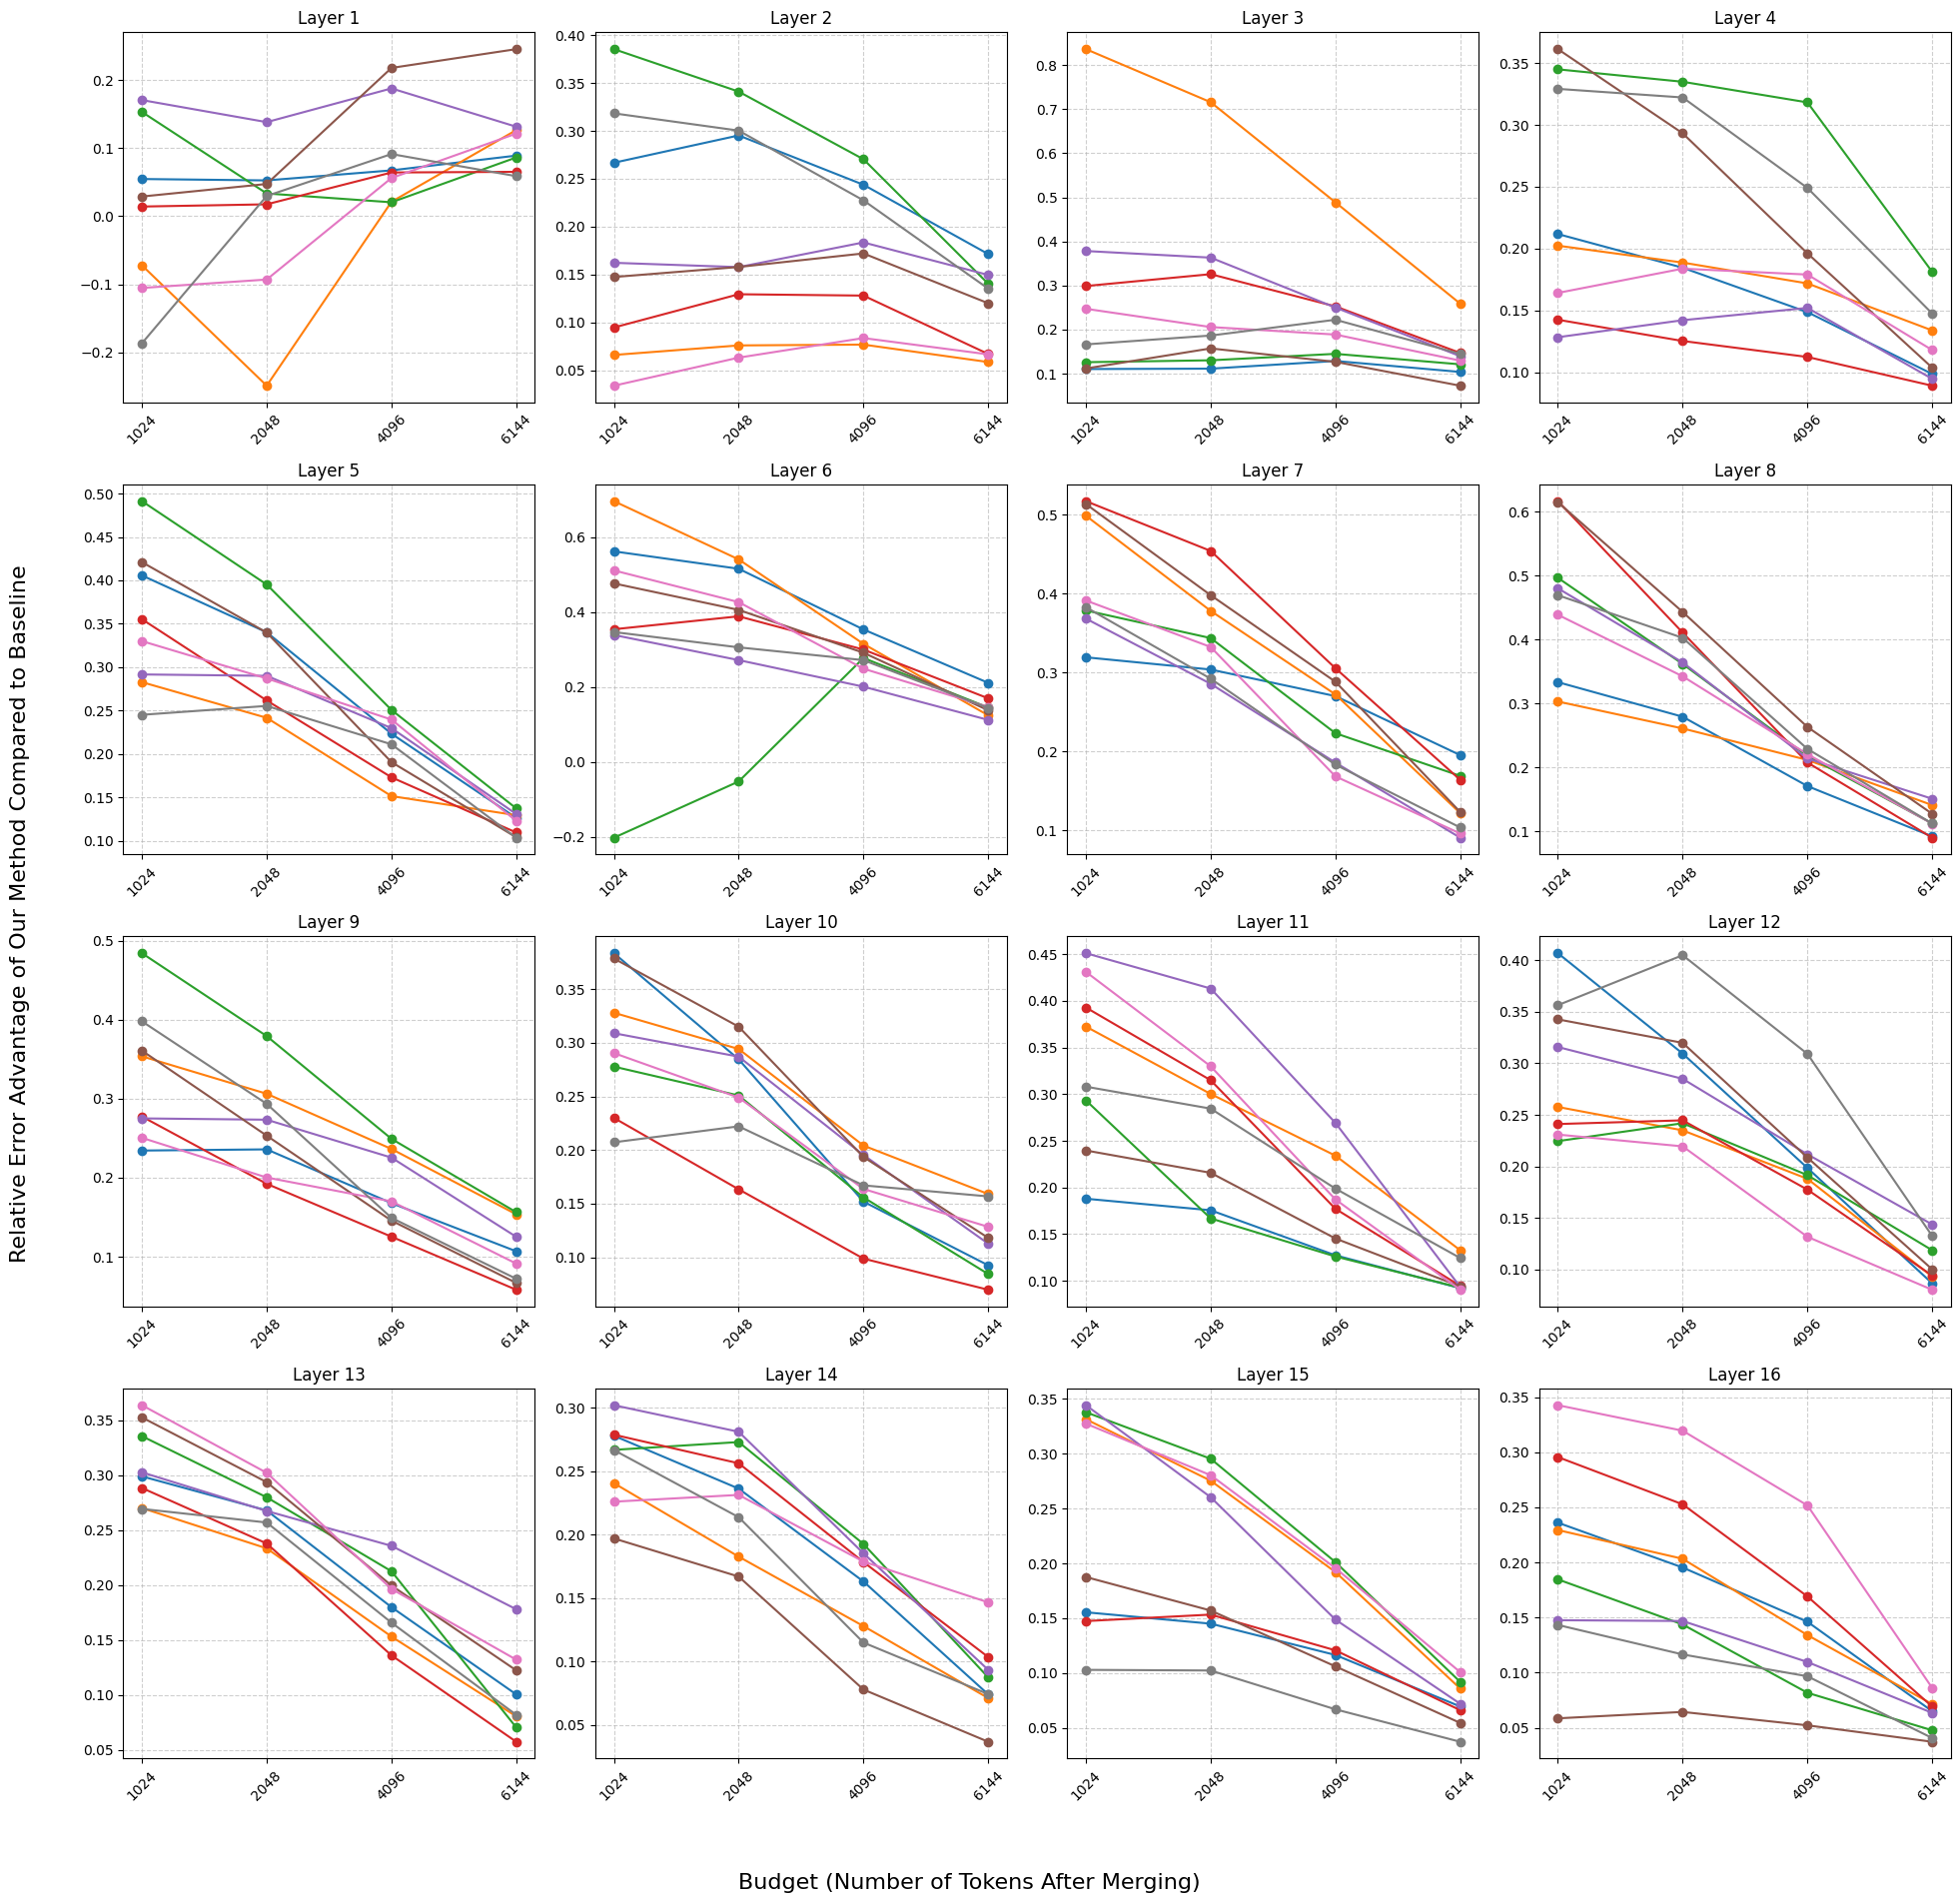

In [20]:
import matplotlib.pyplot as plt

x_labels = [1024, 2048, 4096, 6144]
x_positions = range(len(x_labels)) # This will be [0, 1, 2, 3]
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for l in range(16): # layer
    ax = axs[l//4, l%4]
    
    for h in range(8): # head
        y_values = record[1, l, h] - record[0, l, h]
        ax.plot(x_positions, y_values, label=f'Head {h+1}', marker='o')

    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_title(f'Layer {l+1}')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # 2. The individual axis labels are removed from the loop

# 3. Add a single, centered x and y label for the entire figure
fig.supxlabel('Budget (Number of Tokens After Merging)', fontsize=16)
fig.supylabel('Relative Error Advantage of Our Method Compared to Baseline', fontsize=16)

# Add a single legend to the figure
handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')

plt.tight_layout(rect=[0.03, 0.03, 1, 0.96]) # Adjust rect to make space for the new labels
plt.savefig('/accounts/grad/zhangyunzhe2023/tlide/error_advantage_all_layers_heads.png')
plt.show()